<a href="https://colab.research.google.com/github/evidal1990/data_science/blob/main/data_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Instalando sklearn

In [ ]:
%pip install scikit-learn
%pip install category_encoders
%pip install imbalanced-learn
%pip install catboost


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.8 MB/s eta 0:00:00


#### Importando as bibliotecas necessárias

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from category_encoders import TargetEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
from scipy.stats import randint, uniform
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from catboost import CatBoostClassifier

#### Lendo dados da base após análise

In [ ]:
df_accidents = pd.read_csv(
    "/content/datatran2018_2024_v3.csv",
    parse_dates=["mes_ano"]
)
df_accidents.info()
df_accidents.reset_index(drop=True, inplace=True)

<ipython-input-3-67dda1da5154>:1: DtypeWarning: Columns (0,2,3,4,5,7,8,9,10,11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  df_accidents = pd.read_csv(


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 467078 entries, 0 to 467077
Data columns (total 15 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   tipo_data               429733 non-null  object        
 1   mes_ano                 467078 non-null  datetime64[ns]
 2   dia_semana              429733 non-null  object        
 3   fase_dia                429733 non-null  object        
 4   condicao_metereologica  429733 non-null  object        
 5   uf                      429733 non-null  object        
 6   br                      429733 non-null  float64       
 7   uso_solo                429733 non-null  object        
 8   tipo_pista              429733 non-null  object        
 9   sentido_via             429733 non-null  object        
 10  tipo_acidente           429733 non-null  object        
 11  causa_acidente          429733 non-null  object        
 12  classificacao_acidente  429733

#### Removendo colunas que não serão utilizadas para a classificação

In [ ]:
df = df_accidents.copy()
df.drop(columns=[
    "uf",
    "mes_ano",
    "tipo_data",
    "classificacao_acidente",
    "pessoas",
    "veiculos"
], inplace=True)

df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 429733 entries, 0 to 429732
Data columns (total 9 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   dia_semana              429733 non-null  object 
 1   fase_dia                429733 non-null  object 
 2   condicao_metereologica  429733 non-null  object 
 3   br                      429733 non-null  float64
 4   uso_solo                429733 non-null  object 
 5   tipo_pista              429733 non-null  object 
 6   sentido_via             429733 non-null  object 
 7   tipo_acidente           429733 non-null  object 
 8   causa_acidente          429733 non-null  object 
dtypes: float64(1), object(8)
memory usage: 32.8+ MB


#### Agrupando tipos de acidente para facilitar a classificação

In [ ]:
df["tipo_acidente"].value_counts()

,count
tipo_acidente,
Colisão traseira,81314
Saída de leito carroçável,67518
Colisão transversal,54276
Tombamento,35660
Colisão frontal,28970
Colisão lateral,24476
Colisão lateral mesmo sentido,23272
Atropelamento de pedestre,19884
Queda de ocupante de veículo,19182


#### Removendo todos os acidentes que não são do tipo Colisão

In [ ]:
accidents = {
    "Colisão traseira": "Colisão",
    "Colisão transversal": "Colisão",
    "Colisão frontal": "Colisão",
    "Colisão lateral": "Colisão",
    "Colisão lateral mesmo sentido": "Colisão",
    "Colisão lateral sentido oposto": "Colisão",
    "Colisão com objeto": "Colisão",
    "Colisão com objeto estático": "Colisão",
    "Colisão com objeto em movimento": "Colisão",
    "Atropelamento de animal": "Atropelamento",
    "Atropelamento de pedestre": "Atropelamento",
    "Capotamento": "Perda de controle",
    "Tombamento": "Perda de controle",
    "Saída de leito carroçável": "Perda de controle",
    "Engavetamento": "Perda de controle",
    "Derramamento de carga": "Outros",
    "Incêndio": "Outros",
    "Eventos atípicos": "Outros",
    "Danos eventuais": "Outros",
    "Queda de ocupante de veículo": "Outros"
}

df["tipo_acidente"] = df["tipo_acidente"].map(accidents)
df["tipo_acidente"].value_counts()

,count
tipo_acidente,
Colisão,250566
Perda de controle,122029
Outros,29917
Atropelamento,27221


#### Definir target

In [ ]:
target_col = 'tipo_acidente'

#### Definir variáveis

In [ ]:
# 1. Definir variáveis
categorical_features = [
    'dia_semana',
    'fase_dia',
    'condicao_metereologica',
    'uso_solo',
    'tipo_pista',
    'sentido_via',
    'causa_acidente'
]

#### Separar dados

In [ ]:
X = df[categorical_features]
y = df[target_col]

#### OneHotEncoder + RandomForestClassifier

Gera variáveis binárias, o que mantém a informação completa das categorias. Funciona bem com RandomForest, que lida naturalmente com dados esparsos. Porém, com alta cardinalidade, a explosão de colunas aumenta muito o consumo de memória e processamento, impactando escalabilidade.

In [ ]:
# 1. Separar treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# 2. Pipeline
preprocessor = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(
        class_weight='balanced',
        random_state=42
    ))
])

# 3. Hiperparâmetros
param_distributions = {
    'classifier__n_estimators': randint(50, 100),
    'classifier__max_depth': randint(5, 10),
    'classifier__min_samples_split': randint(2, 11),
    'classifier__min_samples_leaf': randint(1, 5),
    'classifier__bootstrap': [True, False]
}

# 4. Random Search
random_search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_distributions,
    n_iter=10,
    cv=3,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

# 5. Treinar o modelo
random_search.fit(X_train, y_train)

# 6. Melhores parâmetros
print("Melhores parâmetros:", random_search.best_params_)
print("Melhor score (balanced_accuracy):", random_search.best_score_)

# 7. Prever
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)

# 8. Avaliar
print(classification_report(y_test, y_pred))

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Melhores parâmetros: {'classifier__bootstrap': True, 'classifier__max_depth': 9, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 9, 'classifier__n_estimators': 93}
Melhor score (balanced_accuracy): 0.6352551252771655
                   precision    recall  f1-score   support

    Atropelamento       0.86      0.73      0.79      8166
          Colisão       0.80      0.63      0.71     75170
           Outros       0.41      0.40      0.41      8975
Perda de controle       0.46      0.68      0.55     36609

         accuracy                           0.63    128920
        macro avg       0.63      0.61      0.61    128920
     weighted avg       0.68      0.63      0.65    128920



#### Matriz de confusão

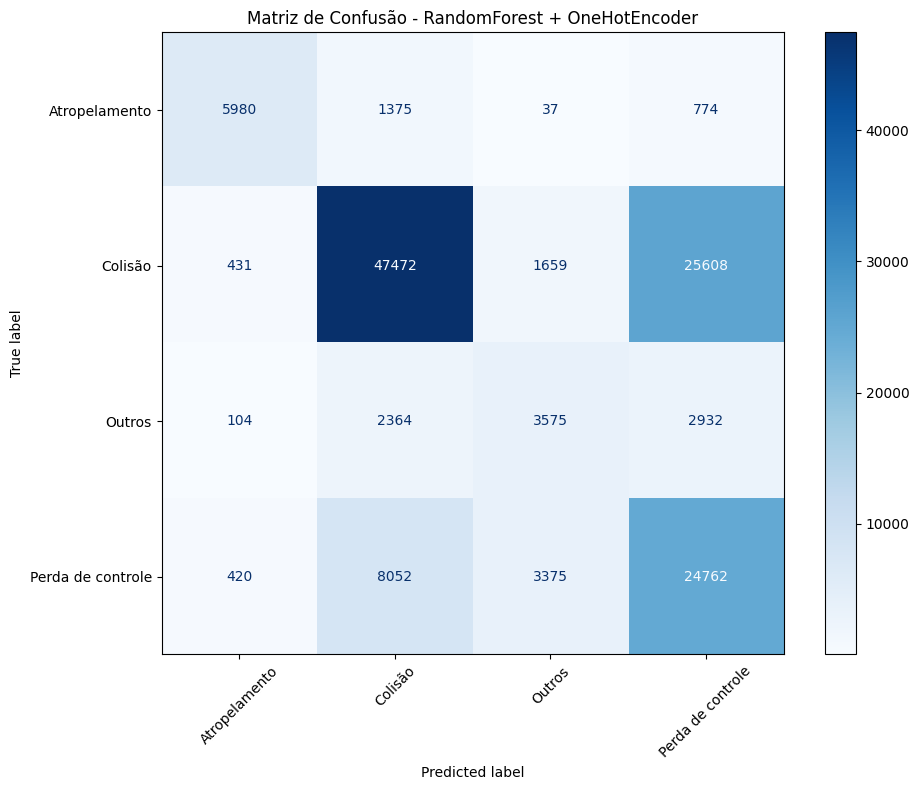

In [ ]:
cm = confusion_matrix(y_test, y_pred, labels=random_search.best_estimator_.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=random_search.best_estimator_.classes_)

fig, ax = plt.subplots(figsize=(10, 8))
disp.plot(ax=ax, cmap='Blues', xticks_rotation=45)
plt.title('Matriz de Confusão - RandomForest + OneHotEncoder')
plt.tight_layout()
plt.show()

#### TargetEncoder + RandomForestClassifier

Codifica categorias pela média do target, reduzindo dimensionalidade. RandomForest lida bem com essa codificação, aproveitando as informações numéricas sem o custo da explosão de features, mantendo boa performance e escalabilidade mesmo com dados grandes e muitas categorias.

In [ ]:
# 1. Separar treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# 2. Pipeline
pipeline = Pipeline([
    ('encoder', TargetEncoder(cols=categorical_features)),
    ('clf', RandomForestClassifier(class_weight='balanced', random_state=42))
])

# 3. Hiperparâmetros
param_distributions = {
    'clf__n_estimators': randint(50, 100),          # de 50 até 149
    'clf__max_depth': randint(5, 10),               # de 5 até 19
    'clf__min_samples_split': randint(2, 11),       # de 2 até 10
    'clf__min_samples_leaf': randint(1, 5),         # de 1 até 4
    'clf__max_features': ['sqrt', 'log2']
}

# 4. Random Search
random_search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_distributions,
    n_iter=10,
    cv=3,
    scoring='balanced_accuracy',
    n_jobs=2,
    random_state=42,
    verbose=1
)

# 5. Busca
random_search.fit(X_train, y_train)

# 6. Melhores parâmetros
print("Melhores parâmetros:", random_search.best_params_)
print("Melhor score (balanced_accuracy):", random_search.best_score_)

# 7. Prever
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)

# 8. Avaliar
print(classification_report(y_test, y_pred))

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Melhores parâmetros: {'clf__max_depth': 8, 'clf__max_features': 'sqrt', 'clf__min_samples_leaf': 3, 'clf__min_samples_split': 9, 'clf__n_estimators': 70}
Melhor score (balanced_accuracy): 0.6251466469544137
                   precision    recall  f1-score   support

    Atropelamento       0.84      0.74      0.79      8166
          Colisão       0.81      0.69      0.74     75170
           Outros       0.27      0.48      0.35      8975
Perda de controle       0.51      0.59      0.55     36609

         accuracy                           0.65    128920
        macro avg       0.61      0.62      0.61    128920
     weighted avg       0.69      0.65      0.66    128920



#### Matriz de confusão

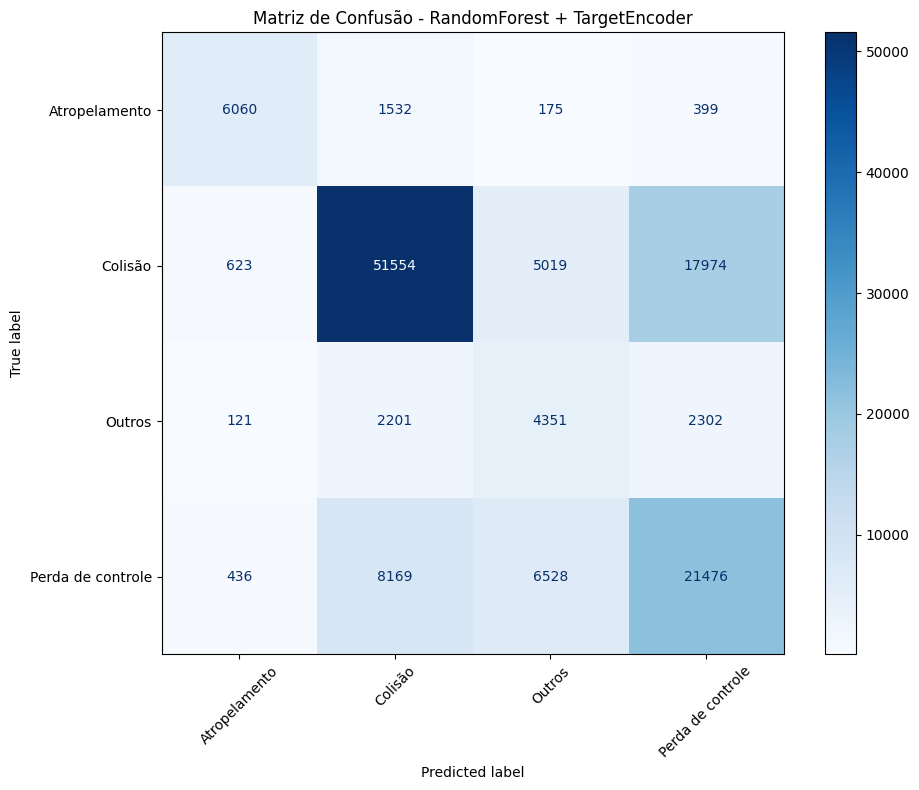

In [ ]:
cm = confusion_matrix(y_test, y_pred, labels=best_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)

fig, ax = plt.subplots(figsize=(10, 8))
disp.plot(ax=ax, cmap='Blues', xticks_rotation=45)
plt.title('Matriz de Confusão - RandomForest + TargetEncoder')
plt.tight_layout()
plt.show()


#### TargetEncoder + DecisionTreeClassifier

Simples e eficiente, reduz dimensionalidade e facilita a construção da árvore. Porém, DecisionTree é mais propenso a overfitting que RandomForest, pois não tem mecanismos internos de regularização tão eficazes, embora seja rápido e interpretável para dados menores ou mais simples.

In [ ]:
# 1. Separar treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# 2. Pipeline
pipeline = Pipeline([
    ('encoder', TargetEncoder(cols=categorical_features)),
    ('clf', DecisionTreeClassifier(class_weight='balanced', random_state=42))
])

# 3. Hiperparâmetros
param_distributions = {
    'clf__max_depth': randint(5, 10),               # de 5 até 19
    'clf__min_samples_split': randint(2, 11),       # de 2 até 10
    'clf__min_samples_leaf': randint(1, 5),         # de 1 até 4
    'clf__max_features': ['sqrt', 'log2']
}

# 4. Random Search
random_search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_distributions,
    n_iter=10,
    cv=3,
    scoring='neg_log_loss',
    n_jobs=2,
    verbose=1
)

# 5. Busca
random_search.fit(X_train, y_train)

# 6. Melhores parâmetros
print("Melhores parâmetros:", random_search.best_params_)
print("Melhor score (balanced_accuracy):", random_search.best_score_)

# 7. Prever
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)

# 8. Avaliar
print(classification_report(y_test, y_pred))

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Melhores parâmetros: {'clf__max_depth': 7, 'clf__max_features': 'log2', 'clf__min_samples_leaf': 4, 'clf__min_samples_split': 6}
Melhor score (balanced_accuracy): -1.0043026012854892
                   precision    recall  f1-score   support

    Atropelamento       0.84      0.74      0.79      8166
          Colisão       0.83      0.60      0.70     75170
           Outros       0.21      0.55      0.30      8975
Perda de controle       0.47      0.56      0.51     36609

         accuracy                           0.59    128920
        macro avg       0.59      0.61      0.57    128920
     weighted avg       0.69      0.59      0.62    128920



#### Matriz de confusão

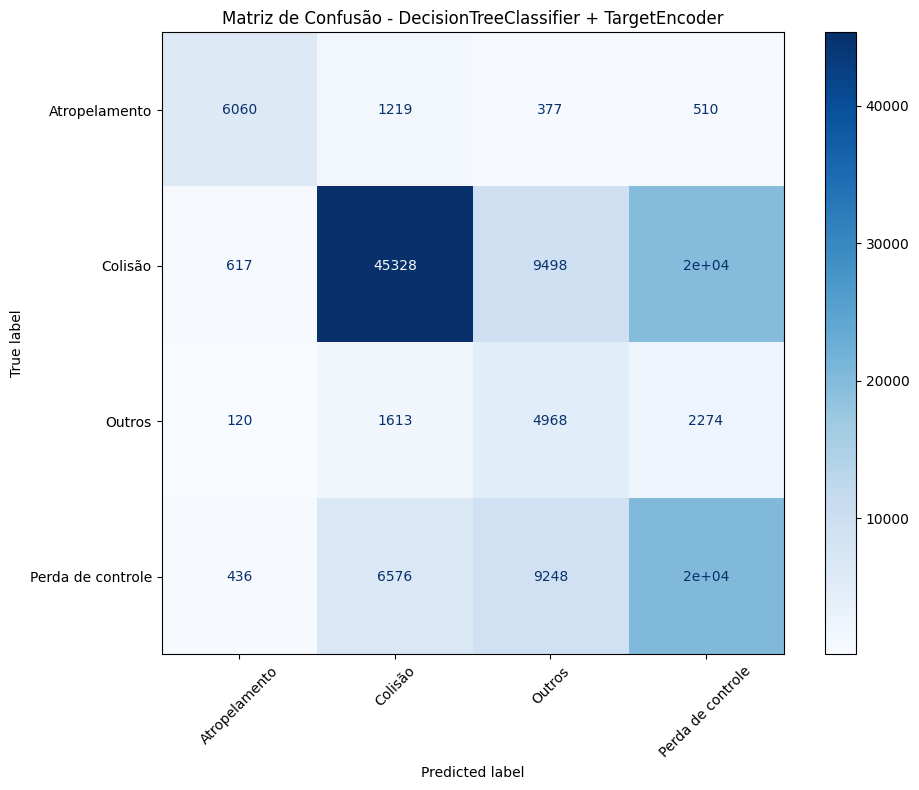

In [ ]:
cm = confusion_matrix(y_test, y_pred, labels=best_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)

fig, ax = plt.subplots(figsize=(10, 8))
disp.plot(ax=ax, cmap='Blues', xticks_rotation=45)
plt.title('Matriz de Confusão - DecisionTreeClassifier + TargetEncoder')
plt.tight_layout()
plt.show()


#### TargetEnconder + XGBoost

Combinação muito eficiente. TargetEncoder transforma categorias em valores numéricos densos, o que é ideal para XGBoost, que espera entradas numéricas. XGBoost lida muito bem com grandes volumes, possui regularização e técnicas internas que evitam overfitting e aumentam a precisão.

In [ ]:
# 1. Separar treino e teste
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.3, stratify=y_encoded, random_state=42
)

# 2. Aplicar encoding nas features categóricas antes do SMOTE
encoder = TargetEncoder(cols=categorical_features)
X_train_encoded = encoder.fit_transform(X_train, y_train)
X_test_encoded = encoder.transform(X_test)

# 3. Aplicar SMOTE apenas nos dados de treino codificados
smote = SMOTE(random_state=42)

# 4. Aplicar SMOTE para gerar novas amostras na base de treino codificada
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_encoded, y_train)

# 5. Pipeline
pipeline = Pipeline([
    ('encoder', TargetEncoder(cols=categorical_features)),
    ('clf', XGBClassifier(
        objective='multi:softprob',
        eval_metric='mlogloss',
        random_state=42,
        n_jobs=-1
    ))
])

# 6. Hiperparâmetros
param_distributions = {
    'clf__n_estimators': randint(50, 150),
    'clf__max_depth': randint(3, 10),
    'clf__learning_rate': uniform(0.01, 0.3),
    'clf__subsample': uniform(0.6, 0.4),
    'clf__colsample_bytree': uniform(0.6, 0.4),
    'clf__gamma': uniform(0, 5)
}

# 7. Random Search
random_search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_distributions,
    n_iter=10,
    cv=3,
    scoring='recall_macro',
    n_jobs=1,
    random_state=42,
    verbose=1,
    error_score='raise'
)

# 8. Busca
random_search.fit(X_train_resampled, y_train_resampled)

# 9. Melhores parâmetros
print("Melhores parâmetros:", random_search.best_params_)
print("Melhor score (recall_macro):", random_search.best_score_)

# 10. Prever
best_model = random_search.best_estimator_
# Lembre-se de prever no X_test_encoded, não no X_test original
y_pred = best_model.predict(X_test_encoded)

# 11. Avaliar
y_test_labels = label_encoder.inverse_transform(y_test)
y_pred_labels = label_encoder.inverse_transform(y_pred)
print(classification_report(y_test_labels, y_pred_labels))

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Melhores parâmetros: {'clf__colsample_bytree': np.float64(0.7599443886861021), 'clf__gamma': np.float64(0.23332831606807714), 'clf__learning_rate': np.float64(0.30212665565243774), 'clf__max_depth': 9, 'clf__n_estimators': 111, 'clf__subsample': np.float64(0.6362425738131283)}
Melhor score (recall_macro): 0.6330375275765178
                   precision    recall  f1-score   support

    Atropelamento       0.82      0.75      0.78      8166
          Colisão       0.80      0.71      0.75     75170
           Outros       0.41      0.40      0.40      8975
Perda de controle       0.51      0.64      0.57     36609

         accuracy                           0.67    128920
        macro avg       0.63      0.63      0.63    128920
     weighted avg       0.69      0.67      0.68    128920



#### Matriz de confusão

Text(0.5, 1.0, 'Matriz de Confusão')

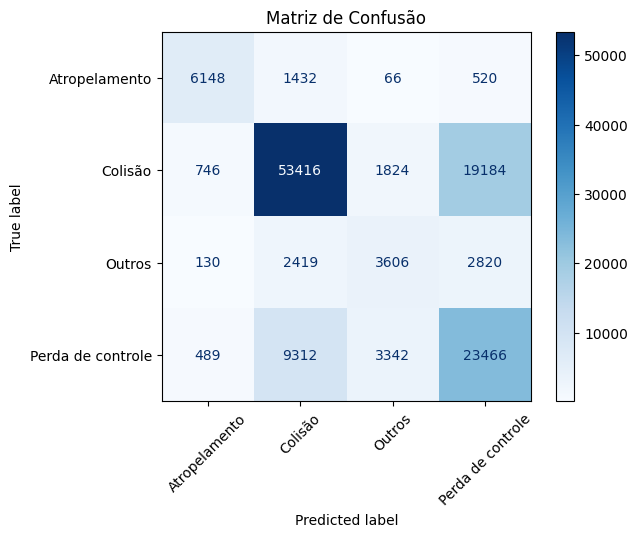

In [ ]:
disp = ConfusionMatrixDisplay.from_predictions(
    y_test_labels, y_pred_labels,
    display_labels=label_encoder.classes_,
    xticks_rotation=45,
    cmap="Blues"
)
disp.ax_.set_title("Matriz de Confusão")

#### CatBoost

Ideal para dados categóricos, pois lida nativamente com eles sem necessidade de encoding manual. Reduz risco de overfitting, entrega alta performance, é eficiente com grandes volumes e simplifica o pipeline, além de ser robusto mesmo com alta cardinalidade nas categorias.

In [ ]:
# 1. Separar treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# 2. Modelo com otimizações
model = CatBoostClassifier(
    verbose=0,
    random_state=42,
    cat_features=[X.columns.get_loc(col) for col in categorical_features],
    early_stopping_rounds=20
)

# 3. Hiperparâmetros
param_dist = {
    'iterations': randint(100, 200),
    'depth': randint(4, 7),
    'learning_rate': uniform(0.03, 0.07),
    'l2_leaf_reg': randint(2, 5),
    'border_count': randint(32, 64)
}

# 4. Random Search
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=5,
    scoring='accuracy',
    cv=2,
    verbose=3,
    random_state=42,
    n_jobs=-1
)

# 5. Busca
random_search.fit(X_train, y_train)

# 6. Melhoras parâmetros
print("Melhores parâmetros:", random_search.best_params_)
print("Melhor score (cv):", random_search.best_score_)

# 7. Prever
y_pred = random_search.predict(X_test)

# 8. Avaliar
print("\nRelatório de Classificação:\n")
print(classification_report(y_test, y_pred))

Fitting 2 folds for each of 5 candidates, totalling 10 fits


KeyboardInterrupt: 

### Modelo escolhido

Considerando a performance das combinações acima, o modelo escolhido é o TargetEncoder + XGBoost por ter uma acurácia de 67% (a maior até agora).